In [ ]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import matplotlib.pyplot as plt
import re
import numpy as np
from numpy.random import default_rng
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.optimize import root_scalar
from scipy.stats import norm
from scipy.integrate import quad, quad_vec
from scipy.special import log_ndtr
from functools import partial
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import time

def convert_to_numerical_binary_vectors(x: np.ndarray, N: int) -> np.ndarray:
    """
    Converte ogni coppia di interi in un array NumPy in un singolo vettore
    numerico di bit (0 e 1), adattandosi dinamicamente a N.
    """
    num_bits = int(N / 2)
    final_vectors = []

    # Crea la stringa di formattazione dinamicamente
    format_spec = f'{{:0{num_bits}b}}'

    for row in x:
        # Applica la formattazione per ogni numero
        bin_str_1 = format_spec.format(row[0])
        bin_str_2 = format_spec.format(row[1])
        concatenated_string = bin_str_1 + bin_str_2

        numerical_vector = [int(bit) for bit in concatenated_string]
        final_vectors.append(numerical_vector)

    bin_var = np.array(final_vectors, dtype=np.int8)
    ising_var = 2 * bin_var - 1

    return ising_var

def define_perfect_perceptron(N = 20):
    """
    Inizializzazione dell'array di pesi del Perceptron perfetto.
    """
    positive_part = 2 ** np.arange((N/2) -1, -1, -1)
    return np.concatenate((positive_part, -positive_part))

class Perceptron:
  def __init__(self, N=20, J=None, seed=None):
    self.seed = seed
    self.rng = np.random.default_rng(seed)
    self.N = N

    if J is None:
      self.J = self.rng.normal(0, 1, self.N)
    else:
      self.J = J

    self.evolution_J = []

  def _sign_activation(self, x):
    x = np.asarray(x)
    return np.where(x > 0, 1, -1)

  def predict(self, x_binary):
    """Esegue predizioni usando i coefficienti del modello fittato."""
    return self._sign_activation(np.dot(x_binary, self.J))

  def evaluate(self, x_binary, y):
    """Calcola l'errore medio di classificazione."""
    y_pred = self.predict(x_binary)
    y = np.atleast_1d(y)
    return np.mean(y_pred != y)

  def fit(self, x_binary, y, epochs=5000):
    """
    Fitta il modello sui dati con la logica di training corretta.
    """
    # Salva lo stato iniziale
    self.evolution_J.append(self.J.copy())

    for epoch in range(epochs):
        updates_in_epoch = 0

        combined_data = list(zip(x_binary, y))
        self.rng.shuffle(combined_data)

        for xi, yi in combined_data:
            yi_pred = self.predict(xi.reshape(1, -1))

            if yi_pred[0] != yi:
                updates_in_epoch += 1

                self.J += (yi * xi) / np.sqrt(self.N)

        self.evolution_J.append(self.J.copy())

        if updates_in_epoch == 0 and epoch > 0:
            print(f"Convergenza raggiunta all'epoca {epoch + 1}.")
            return self.J.copy()

    print(f"Training terminato dopo {epochs} epoche (max epoche raggiunto).")
    return self.J.copy()


  def fit_noise(self, x_binary, y, sigma2=50, epochs=5000):
    """
    Fitta il modello sui dati di training con l'aggiunta di rumore gaussiano.
    """
    # Salva lo stato iniziale
    self.evolution_J.append(self.J.copy())

    for epoch in range(epochs):
        updates_in_epoch = 0

        combined_data = list(zip(x_binary, y))
        self.rng.shuffle(combined_data)

        for xi, yi in combined_data:
            yi_pred = self.predict(xi.reshape(1, -1))

            if yi_pred[0] != yi:
                updates_in_epoch += 1
                r_vector = self.rng.normal(0, np.sqrt(sigma2), size=self.N)
                self.J += (1 + r_vector)*(yi * xi) / np.sqrt(self.N)


        self.evolution_J.append(self.J.copy())

        if updates_in_epoch == 0 and epoch > 0:
            # print(f"Convergenza del training con noise (mu=0, sigma^2={sigma2}) raggiunta all'epoca {epoch + 1}.")
            return self.J.copy()

    print(f"Training con noise terminato dopo {epochs} epoche (max epoche raggiunto).")
    return self.J.copy()

class SyntheticDataGenerator:
  def __init__(self, seed=None, N=20):
    self.seed = seed
    self.rng = np.random.default_rng(seed)
    self.N = N
    self.teacher = Perceptron(N=N, J=define_perfect_perceptron(N))

  def generate_data(self, P):
    """
    Genera un set completo di dati (x, y) di P campioni,
    assicurandosi che nessuna coppia (a, b) abbia a == b.
    """
    x = self.rng.integers(2**(self.N/2), size=(P, 2))

    duplicate_mask = (x[:, 0] == x[:, 1])
    num_duplicates = np.sum(duplicate_mask)

    while num_duplicates > 0:
      new_samples = self.rng.integers(2**(self.N/2), size=(num_duplicates, 2))

      x[duplicate_mask] = new_samples

      duplicate_mask = (x[:, 0] == x[:, 1])
      num_duplicates = np.sum(duplicate_mask)

    y = self.teacher.predict(convert_to_numerical_binary_vectors(x, self.N))

    return convert_to_numerical_binary_vectors(x, self.N), y

In [43]:
# ==============================================================================
#     DEFINIZIONI MATEMATICHE E TEORICHE (ANNEALED)
# Funzioni pure che implementano la teoria. Non dipendono da classi o stato.
# ==============================================================================

def parametric_alphas_annealed(eps):
    """Calcola alpha(eps) per la teoria annealed in modo parametric_solver."""
    safe_eps = np.clip(np.asarray(eps), 1e-9, 0.5 - 1e-9)
    return np.pi * (1 - safe_eps) / (np.tan(np.pi * safe_eps) + 1e-9)

def f1_annealed(eps, alpha):
    """Prima mappa iterativa per la teoria annealed."""
    return 1 - alpha * np.tan(np.pi * eps) / np.pi

def f2_annealed(eps, alpha):
    """Seconda mappa iterativa per la teoria annealed."""
    return np.arctan((np.pi * (1 - eps)) / alpha) / np.pi


# ==============================================================================
#     DEFINIZIONI MATEMATICHE E TEORICHE (QUENCHED)
# Funzioni pure che implementano la teoria. Non dipendono da classi o stato.
# ==============================================================================

def I_R(R):
    """Calcola l'integrale I(R) per un singolo valore di R."""
    if R < 0 or R >= 1: return np.nan
    def integrand(v, R_val):
        log_H = log_ndtr(np.sqrt(R_val) * v)
        return np.exp(-0.5 * (1 + R_val) * v**2 - log_H) / np.sqrt(2 * np.pi)
    result, _ = quad(integrand, -np.inf, np.inf, args=(R,))
    return result

def I_R_vec(R_array):
    """Versione vettorizzata di I_R che preserva la forma dell'input."""
    original_shape = R_array.shape
    R_flat = R_array.flatten() # Lavoriamo su un array appiattito

    valid_mask = (R_flat >= 0) & (R_flat < 1)
    results_flat = np.full_like(R_flat, np.nan, dtype=float)

    if np.any(valid_mask):
        valid_R = R_flat[valid_mask]
        res_quad, _ = quad_vec(
            lambda v, r: np.exp(-0.5 * (1 + r) * v**2 - log_ndtr(np.sqrt(r) * v)),
            -np.inf, np.inf, args=(valid_R,)
        )
        results_flat[valid_mask] = res_quad / np.sqrt(2 * np.pi)

    # Rimodelliamo il risultato alla forma originale dell'input
    return results_flat.reshape(original_shape)

def f1_quenched(R, alpha):
  """Funzione f1 corretta per gestire alpha sia come scalare che come array."""
  R = np.asarray(R)
  # alpha può essere uno scalare o un array, il broadcasting gestirà entrambi i casi

  I_val = I_R_vec(R)

  # Calcoliamo il risultato direttamente. Se R, alpha o I_val sono NaN,
  # il risultato sarà NaN, il che è corretto.
  return (alpha / np.pi) * np.sqrt(1 - R) * I_val

def f2_quenched(R, alpha):
  """Funzione f2 corretta per gestire alpha sia come scalare che come array."""
  R = np.asarray(R)
  alpha = np.asarray(alpha) # Convertire in array per ndim

  I_val = I_R_vec(R)

  # Il denominatore è il punto critico
  denominator = alpha**2 * I_val**2

  # Condizione per un calcolo valido
  valid_condition = (denominator > 1e-18) & (R >= 0) & (R < 1)

  # Calcola il rapporto solo dove la condizione è valida, altrimenti metti NaN
  ratio = np.divide(
      np.pi**2 * R**2,
      denominator,
      out=np.full_like(R, np.nan),
      where=valid_condition
  )

  return 1 - ratio

def parametric_solver_quenched(R_values):
    """Calcola alpha data una serie di R (il punto fisso)."""
    R_values = np.asarray(R_values)
    mask = (R_values > 0) & (R_values < 1)
    alphas = np.full_like(R_values, np.nan)
    if np.any(mask):
        valid_R = R_values[mask]
        lhs = (np.pi * valid_R) / np.sqrt(1 - valid_R)
        rhs = I_R_vec(valid_R)
        alphas[mask] = lhs / rhs
    return alphas


# ==============================================================================
#     PROCEDURE NUMERICHE GENERALI
# Funzioni per l'analisi numerica che possono essere riutilizzate.
# ==============================================================================

def vectorized_iterative_procedure(alphas, x_0, a, f, max_epochs=2000, tol=1e-8):
    """
    Calcola l'evoluzione di una mappa iterativa per un array di `alphas`.
    Restituisce la matrice della storia dell'evoluzione.
    """
    alphas = np.asarray(alphas)
    num_alphas = len(alphas)
    old_x = np.full(num_alphas, float(x_0))
    history = np.zeros((max_epochs, num_alphas))

    for epoch in range(max_epochs):
        new_x = (1 - a) * old_x + a * f(old_x, alphas)
        history[epoch, :] = new_x

        if np.all(np.abs(new_x - old_x) < tol):
            print(f"Convergenza raggiunta all'epoca {epoch + 1}.")
            history[epoch+1:, :] = new_x
            return history[:epoch + 1]

        old_x = new_x

    print(f"Attenzione: Max epoche ({max_epochs}) raggiunto.")
    return history

def evolution_vs_a_procedure(alpha, x_0, a_values, f, max_epochs=200):
    """Calcola l'evoluzione per un alpha fisso e diversi valori di `a`."""
    a_values = np.asarray(a_values)
    num_a = len(a_values)
    old_x = np.full(num_a, float(x_0))
    history = np.zeros((max_epochs, num_a))

    for epoch in range(max_epochs):
        f_val = f(old_x, alpha)
        new_x = (1 - a_values) * old_x + a_values * f_val
        history[epoch, :] = new_x
        old_x = new_x

    return history

def numerical_derivative(f, x, alpha, h=1e-6):
    """Calcola la derivata numerica di f(x, alpha) rispetto a x."""
    return (f(x + h, alpha) - f(x - h, alpha)) / (2 * h)

def hybrid_iterative_procedure(
    alphas,
    eps_0,
    a,
    f1,
    f2,
    crossover_alpha,
    max_epochs=2000,
    tol=1e-8
):
    """
    Esegue una procedura iterativa ibrida.

    Usa la funzione f1 per alpha <= crossover_alpha e f2 per alpha > crossover_alpha.

    Args:
        alphas (np.array): Array di valori di alpha.
        eps_0 (float): Punto di partenza dell'iterazione.
        a (float): Parametro di rilassamento.
        f1 (callable): Funzione iterativa per alpha piccoli.
        f2 (callable): Funzione iterativa per alpha grandi.
        crossover_alpha (float): Valore di alpha in cui si passa da f1 a f2.
        max_epochs (int): Numero massimo di iterazioni.
        tol (float): Tolleranza per la convergenza.

    Returns:
        np.array: Array dei punti fissi trovati per ogni alpha.
    """
    alphas = np.asarray(alphas)

    # 1. Definiamo la funzione ibrida 'f_hybrid'
    def f_hybrid(eps_array, alpha_array):
        # Inizializziamo l'output con NaN
        results = np.full_like(eps_array, np.nan)

        # Maschera per decidere quale funzione usare
        mask_f1 = (alpha_array <= crossover_alpha)
        mask_f2 = (alpha_array > crossover_alpha)

        # Applica f1 dove la maschera è vera
        if np.any(mask_f1):
            results[mask_f1] = f1(eps_array[mask_f1], alpha_array[mask_f1])

        # Applica f2 dove la maschera è vera
        if np.any(mask_f2):
            results[mask_f2] = f2(eps_array[mask_f2], alpha_array[mask_f2])

        return results

    # 2. Esegui la procedura vettorizzata con la funzione ibrida
    print(f"Esecuzione procedura ibrida con crossover a alpha = {crossover_alpha}...")
    evolution_matrix = vectorized_iterative_procedure(
        alphas,
        eps_0,
        a,
        f_hybrid,
        max_epochs,
        tol
    )

    # 3. Estrai e restituisci l'ultimo valore (il punto fisso) per ogni alpha
    fixed_points = evolution_matrix[-1, :]
    return fixed_points

# ==============================================================================
#     FUNZIONI DI VISUALIZZAZIONE
# Funzioni dedicate al plotting, separate dalla logica di calcolo.
# ==============================================================================

def compare_dynamics(f1, f2, alpha, x_0, a_values, max_epochs, interval=[0.001, 0.999]):
    """Esegue e plotta la dinamica di convergenza per f1 e f2."""
    print("--- Calcolo Dinamiche di Convergenza ---")
    evo1 = evolution_vs_a_procedure(alpha, x_0, a_values, f1, max_epochs)
    evo2 = evolution_vs_a_procedure(alpha, x_0, a_values, f2, max_epochs)

    print("--- Plotting Dinamiche ---")
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(a_values)))

    for ax, evo, f, name in zip(axes, [evo1, evo2], [f1, f2], ["f_1", "f_2"]):
        try:
            pf = root_scalar(lambda x: x - f(x, alpha), x0=x_0, bracket=interval).root
            ax.axhline(pf, color='black', ls='--', label=f'Punto fisso ≈ {pf:.3f}')
        except ValueError:
            print(f"Nessun punto fisso trovato per {name} nell'intervallo.")

        for i, a_val in enumerate(a_values):
            trajectory = np.concatenate(([x_0], evo[:, i]))
            ax.plot(trajectory, label=f'a = {a_val}', color=colors[i], lw=2.5)

        ax.set_title(f'Dinamica per Funzione ${name}$', fontsize=16)
        ax.set_xlabel('Epoca (i)', fontsize=14)
        ax.legend()
        ax.set_ylim(interval)
        ax.grid(True, ls=':', alpha=0.7)

    axes[0].set_ylabel(r'Valore di $R_i$ o $\epsilon_i$', fontsize=14)
    fig.suptitle(f'Confronto Dinamiche per $\\alpha={alpha}$ e $x_0={x_0}$', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_results_annealed(
    f_map=f2_annealed,
    a_fixed=0.9,
    x0_fixed=0.5,
    max_epochs=5000,
    save_figure=False
):
    """
    Genera il grafico che confronta la curva parametrica teorica (Annealed)
    con i punti fissi calcolati tramite la dinamica iterativa.

    Args:
        f_map (callable): La funzione della mappa da usare per l'iterazione (es. f2_annealed).
        a_fixed (float): Valore fisso del parametro di rilassamento 'a'.
        x0_fixed (float): Valore iniziale per l'iterazione.
        max_epochs (int): Numero massimo di epoche per la convergenza.
        save_figure (bool): Se True, salva il grafico su file.
    """
    print("\n--- Esecuzione Plot di Confronto (Annealed) ---")

    # --- 1. Calcolo Curva Teoria Parametrica ---
    print("Calcolo curva teorica parametrica...")
    eps_parametric = np.linspace(1e-9, 0.5 - 1e-9, 500)
    alpha_parametric = parametric_alphas_annealed(eps_parametric)

    # --- 2. Calcolo Punti Fissi da Mappa Iterativa ---
    print(f"Calcolo punti fissi da mappa iterativa (usando {f_map.__name__})...")
    alphas_for_map = np.linspace(0.01, 10, 100)
    evolution_matrix = vectorized_iterative_procedure(
        alphas=alphas_for_map,
        x_0=x0_fixed,
        a=a_fixed,
        f=f_map,
        max_epochs=max_epochs
    )
    eps_from_map = evolution_matrix[-1, :] if evolution_matrix.shape[0] > 0 else np.full_like(alphas_for_map, np.nan)

    # --- 3. Creazione del Grafico ---
    print("--- Calcolo Completato. Inizio Plotting. ---")
    fig, ax = plt.subplots(figsize=(14, 9))

    # Plotta Curva Teoria Parametrica
    ax.plot(
        alpha_parametric,
        eps_parametric,
        color='black',
        linestyle='--',
        linewidth=3,
        label='Teoria Annealed (Parametrica)'
    )

    # Plotta Punti Fissi Trovati
    ax.plot(
        alphas_for_map,
        eps_from_map,
        'o',
        markersize=8,
        color='limegreen',
        markeredgecolor='black',
        label=f'Punti Fissi da Dinamica ({f_map.__name__}, a={a_fixed})'
    )

    # --- 4. Personalizzazione Grafico ---
    ax.set_title(r"Confronto tra Teoria Annealed Parametrica e Dinamica Iterativa", fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = p/N$", fontsize=16)
    ax.set_ylabel(r"$\epsilon$ (Errore di Generalizzazione)", fontsize=16)
    ax.legend(fontsize=14)
    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=-0.02, top=0.55)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()

    if save_figure:
        filename = "annealed_theory_vs_dynamics.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

def plot_results_quenched(plot_in_epsilon=True):
    """
    Genera il grafico che confronta la curva parametrica teorica (quenched)
    con i punti fissi calcolati tramite la procedura iterativa ibrida.

    Permette di visualizzare i risultati in termini di R(alpha) o epsilon(alpha).

    Args:
        plot_in_epsilon (bool): Se True, l'asse y mostra l'errore epsilon.
                                Se False (default), mostra l'overlap R.
    """
    # --- 1. Parametri per la Simulazione ---
    A_FIXED = 0.5
    R_ZERO_FIXED = 0.5  # Punto di partenza per l'overlap R
    CROSSOVER_ALPHA = 2.0
    MAX_EPOCHS_FIXED = 5000

    alphas_for_fixed_point = np.linspace(0.1, 8, 100)

    # --- 2. Calcolo dei Punti Fissi tramite Procedura Ibrida ---
    # La procedura calcola sempre l'overlap R
    fixed_point_R = hybrid_iterative_procedure(
        alphas=alphas_for_fixed_point,
        eps_0=R_ZERO_FIXED,
        a=A_FIXED,
        f1=f1_quenched,
        f2=f2_quenched,
        crossover_alpha=CROSSOVER_ALPHA,
        max_epochs=MAX_EPOCHS_FIXED
    )

    # --- 3. Generazione della Curva Parametrica Teorica ---
    print("\n--- Calcolo della Curva Parametrica Teorica ---")
    r_values_parametric = np.linspace(0.001, 0.999, 500)
    alpha_values_parametric = parametric_solver_quenched(r_values_parametric)

    # --- 4. Conversione a Epsilon (se richiesta) e Impostazione Etichette ---
    if plot_in_epsilon:
        # Conversione dei dati
        y_values_parametric = (1 / np.pi) * np.arccos(r_values_parametric)
        y_values_fixed_point = (1 / np.pi) * np.arccos(fixed_point_R)

        # Impostazione etichette e limiti per epsilon
        title = r"Curva di Apprendimento (Quenched) - Validazione Numerica"
        ylabel = r"$\epsilon_{gen}$ (Errore di Generalizzazione)"
        ylim = (-0.02, 0.52)
    else:
        # I dati rimangono in termini di R
        y_values_parametric = r_values_parametric
        y_values_fixed_point = fixed_point_R

        # Impostazione etichette e limiti per R
        title = r"Validazione del Metodo Iterativo Ibrido (Quenched)"
        ylabel = r"$R^*$ (Overlap di Equilibrio)"
        ylim = (-0.05, 1.05)

    # --- 5. Creazione del Grafico ---
    print("--- Calcolo Completato. Inizio Plotting. ---")
    fig, ax = plt.subplots(figsize=(14, 9))

    # Plotta la curva parametrica teorica
    ax.plot(
        alpha_values_parametric,
        y_values_parametric, # <-- Usa i valori y corretti (R o epsilon)
        color='purple',
        linestyle='--',
        linewidth=2.5,
        label='Teoria Quenched (Parametrica)'
    )

    # Plotta i punti fissi trovati iterativamente
    ax.plot(
        alphas_for_fixed_point,
        y_values_fixed_point, # <-- Usa i valori y corretti (R o epsilon)
        'o',
        markersize=7,
        color='limegreen',
        markeredgecolor='black',
        label=f'Punti Fissi da Dinamica Ibrida (a={A_FIXED})'
    )

    ax.axvline(x=CROSSOVER_ALPHA, color='red', linestyle=':', linewidth=2, label=f'Crossover $\\alpha_c = {CROSSOVER_ALPHA}$')

    # --- 6. Personalizzazione del Grafico ---
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = P/N$", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.legend(fontsize=14)
    ax.grid(True, which='both', linestyle='--', alpha=0.6)

    ax.set_xlim(left=0, right=8)
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.show()

def plot_advanced_comparison(exp_results, save_figure=True):
    """
    Plotta il confronto completo tra dati sperimentali e teorie.
    Include:
    1. Dati sperimentali per N=20 e N=40.
    2. Teoria Annealed (sia parametrica che da mappa iterativa).
    3. Teoria Quenched (sia parametrica che da mappa ibrida).
    """
    print("\n--- Esecuzione Plot di Confronto Completo ---")
    res = exp_results

    # --- 1. Preparazione Dati Sperimentali ---
    alpha_20 = np.array(res['train_sizes_20']) / 20
    sem_20 = res['error_stds_20'] / np.sqrt(res.get('runs_num', 1000))

    alpha_40 = np.array(res['train_sizes_40']) / 40
    sem_40 = res['error_stds_40'] / np.sqrt(res.get('runs_num', 1000))

    # --- 2. Calcolo Teorie Annealed ---
    print("Calcolo teorie Annealed...")
    # Curva parametrica
    eps_param_annealed = np.linspace(1e-9, 0.5 - 1e-9, 500)
    alpha_param_annealed = parametric_alphas_annealed(eps_param_annealed)
    # Punti fissi da mappa iterativa (es. f2)
    alphas_for_annealed_map = np.linspace(0.01, 15, 100)
    evo_matrix_annealed = vectorized_iterative_procedure(
        alphas=alphas_for_annealed_map,
        x_0=0.5,
        a=0.9,
        f=f2_annealed, # Usiamo f2 per l'annealed
        max_epochs=5000
    )
    eps_from_annealed_map = evo_matrix_annealed[-1, :] if evo_matrix_annealed.shape[0] > 0 else np.full_like(alphas_for_annealed_map, np.nan)


    # --- 3. Calcolo Teorie Quenched ---
    print("Calcolo teorie Quenched...")
    # Curva parametrica (esatta)
    r_param_quenched = np.linspace(0.001, 0.999, 500)
    alpha_param_quenched = parametric_solver_quenched(r_param_quenched)
    eps_param_quenched = (1 / np.pi) * np.arccos(r_param_quenched)

    # Punti fissi da procedura ibrida (validazione numerica)
    A_FIXED_HYBRID = 0.5
    R_ZERO_HYBRID = 0.5
    CROSSOVER_ALPHA_HYBRID = 2.0
    alphas_for_hybrid_map = np.linspace(0.1, 15, 100)

    fixed_points_R_quenched = hybrid_iterative_procedure(
        alphas=alphas_for_hybrid_map,
        eps_0=R_ZERO_HYBRID,
        a=A_FIXED_HYBRID,
        f1=f1_quenched,
        f2=f2_quenched,
        crossover_alpha=CROSSOVER_ALPHA_HYBRID
    )
    eps_from_hybrid_map = (1 / np.pi) * np.arccos(fixed_points_R_quenched)

    print("--- Calcoli Teorici Completati. Inizio Plotting. ---")

    # --- 4. Creazione del Grafico ---
    fig, ax = plt.subplots(figsize=(16, 10))

    # --- GRUPPO ANNEALED ---
    ax.plot(alpha_param_annealed, eps_param_annealed, color='deepskyblue', linestyle=':', lw=3,
            label='Annealed (Teoria Parametrica)')
    ax.plot(alphas_for_annealed_map, eps_from_annealed_map, 'P', markersize=8, color='cyan',
            alpha=0.8, markeredgecolor='black', linestyle='None',
            label=r'Annealed (Punti Fissi da $f_2$)')

    # --- GRUPPO QUENCHED ---
    ax.plot(alpha_param_quenched, eps_param_quenched, color='black', linestyle='--', lw=3,
            label='Quenched (Teoria Parametrica)')
    ax.plot(alphas_for_hybrid_map, eps_from_hybrid_map, 'x', markersize=8, color='limegreen',
            label=f'Quenched (Punti Fissi da Ibrido)')

    # --- GRUPPO SPERIMENTALE ---
    ax.errorbar(alpha_20, res['error_means_20'], yerr=sem_20, fmt='o', markersize=8, capsize=5,
                label='Sperimentale N=20 (SEM)', color='royalblue', zorder=10)
    ax.errorbar(alpha_40, res['error_means_40'], yerr=sem_40, fmt='s', markersize=8, capsize=5,
                label='Sperimentale N=40 (SEM)', color='red', zorder=10)

    # --- 5. Personalizzazione Grafico ---
    ax.set_title(r"Confronto Completo: Dati Sperimentali vs Teorie", fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = p/N$", fontsize=16)
    ax.set_ylabel(r"$\langle \epsilon \rangle$ (Errore Medio di Generalizzazione)", fontsize=16)

    # Migliora la legenda
    handles, labels = ax.get_legend_handles_labels()
    # Ordine personalizzato per la legenda per una migliore leggibilità
    order = [4, 5, 2, 3, 0, 1]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=13, ncol=2)

    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.set_xlim(left=0, right=15)
    ax.set_ylim(bottom=-0.02, top=0.55)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()

    if save_figure:
        filename = "master_comparison_plot_final.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

def plot_convergence_analysis(
    f1,
    f2,
    parametric_solver,
    alpha_range=(0.1, 10),
    a_range=(0, 2),
    x_range=(0.001, 0.999),
    grid_resolution=(100, 100),
    a_highlight=None, # NUOVO PARAMETRO: valore di 'a' da evidenziare
    labels={
        'title': 'Analisi di Convergenza della Dinamica Iterativa',
        'x_label': r'$\alpha$',
        'y_label': r'$a$ (parametro di rilassamento)',
        'var_name': 'R'
    }
):
    """
    Analizza e visualizza la stabilità di due mappe iterative f1 e f2.
    Genera due heatmap e un grafico comparativo dell'efficienza.
    Permette di evidenziare l'efficienza per un valore specifico di 'a'.
    """
    print("--- Inizio Analisi di Convergenza ---")

    # 1. Creazione della griglia di parametri
    alpha_vals = np.linspace(alpha_range[0], alpha_range[1], grid_resolution[0])
    a_vals = np.linspace(a_range[0], a_range[1], grid_resolution[1])
    ALPHA_grid, A_grid = np.meshgrid(alpha_vals, a_vals, indexing='ij')

    # 2. Pre-calcolo dei punti fissi x*(alpha)
    print("Pre-calcolo dei punti fissi...")
    # Valori di R per calcolare alpha(R)
    x_solver_grid = np.linspace(x_range[0], x_range[1], 200)
    # Valori di alpha(R) calcolati in modo parametrico
    alpha_solver_grid = parametric_solver(x_solver_grid)
    # Seleziono solo i valori non nan di alpha
    valid_indices = ~np.isnan(alpha_solver_grid)
    # Ordino i valori di alpha per interpolare e
    # visualizzare R(alpha) con alpha crescente
    sorted_indices = np.argsort(alpha_solver_grid[valid_indices])
    # Interpolo i valori, calcolo R(alpha) (alpha(R) monotono posso invertire senza problemi)
    x_star_func = np.interp(
        alpha_vals,
        alpha_solver_grid[valid_indices][sorted_indices],
        x_solver_grid[valid_indices][sorted_indices]
    )

    # 3. Calcolo delle derivate e del fattore di convergenza
    print("Calcolo delle derivate numeriche sulla griglia...")
    f1_prime_1d = numerical_derivative(f1, x_star_func, alpha_vals)
    f2_prime_1d = numerical_derivative(f2, x_star_func, alpha_vals)

    f1_prime_grid = np.tile(f1_prime_1d, (grid_resolution[1], 1)).T
    g1_prime_grid = (1 - A_grid) + A_grid * f1_prime_grid
    C1 = np.abs(g1_prime_grid)

    f2_prime_grid = np.tile(f2_prime_1d, (grid_resolution[1], 1)).T
    g2_prime_grid = (1 - A_grid) + A_grid * f2_prime_grid
    C2 = np.abs(g2_prime_grid)

    # 4. Calcolo della curva a_ottimale
    a_opt1 = 1 / (1 - f1_prime_1d)
    a_opt2 = 1 / (1 - f2_prime_1d)

    print("--- Analisi Completata. Inizio Plotting. ---")

    # 5. Visualizzazione
    fig = plt.figure(figsize=(22, 16))
    gs = GridSpec(2, 2, height_ratios=[3, 2], hspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    ax_comp = fig.add_subplot(gs[1, :])

    levels = [0, 0.2, 0.5, 0.8, 1.0]
    contour_colors = 'white'

    # --- Heatmap per f1 (con highlight di 'a' se specificato) ---
    im1 = ax1.imshow(C1.T, extent=[alpha_range[0], alpha_range[1], a_range[0], a_range[1]], origin='lower', aspect='auto', cmap='viridis_r', vmin=0, vmax=2)
    cs1 = ax1.contour(alpha_vals, a_vals, C1.T, levels=levels, colors=contour_colors, linewidths=1.5)
    ax1.clabel(cs1, inline=True, fontsize=10, fmt='%.1f')
    ax1.plot(alpha_vals, a_opt1, color='red', linestyle='--', label=r'$a_{opt}$')
    if a_highlight is not None:
        ax1.axhline(y=a_highlight, color='cyan', linestyle=':', linewidth=2, label=f'$a = {a_highlight}$')
    ax1.set_title(r"Fattore di Convergenza $|g'(R^*)|$ per $f_1$", fontsize=18)
    ax1.set_xlabel(labels['x_label'], fontsize=14)
    ax1.set_ylabel(labels['y_label'], fontsize=14)
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.5)

    # --- Heatmap per f2 (con highlight di 'a' se specificato) ---
    im2 = ax2.imshow(C2.T, extent=[alpha_range[0], alpha_range[1], a_range[0], a_range[1]], origin='lower', aspect='auto', cmap='viridis_r', vmin=0, vmax=2)
    cs2 = ax2.contour(alpha_vals, a_vals, C2.T, levels=levels, colors=contour_colors, linewidths=1.5)
    ax2.clabel(cs2, inline=True, fontsize=10, fmt='%.1f')
    ax2.plot(alpha_vals, a_opt2, color='red', linestyle='--', label=r'$a_{opt}$')
    if a_highlight is not None:
        ax2.axhline(y=a_highlight, color='cyan', linestyle=':', linewidth=2, label=f'$a = {a_highlight}$')
    ax2.set_title(r"Fattore di Convergenza $|g'(R^*)|$ per $f_2$", fontsize=18)
    ax2.set_xlabel(labels['x_label'], fontsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.5)

    # --- Colorbar ---
    cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', pad=0.02)
    cbar.set_label(r"Fattore di Riduzione dell'Errore $|g'(R^*)|$", fontsize=14, rotation=270, labelpad=25)

    # --- Grafico Comparativo di Efficienza (MODIFICATO) ---
    ax_comp.axhline(y=1.0, color='red', linestyle='--', label='Limite di convergenza')
    ax_comp.fill_between(alpha_vals, 1.0, 10, color='red', alpha=0.1, label='Regione di Divergenza')
    ax_comp.fill_between(alpha_vals, 0, 1.0, color='green', alpha=0.1, label='Regione di Convergenza')

    # Efficienza per a=1 (riferimento)
    g1_prime_a1 = np.abs(f1_prime_1d)
    g2_prime_a1 = np.abs(f2_prime_1d)
    ax_comp.plot(alpha_vals, g1_prime_a1, label=r"$|g'|$ per $f_1$ con $a=1$", color='royalblue', linestyle=':', linewidth=2)
    ax_comp.plot(alpha_vals, g2_prime_a1, label=r"$|g'|$ per $f_2$ con $a=1$", color='darkorange', linestyle=':', linewidth=2)

    # Efficienza per a_highlight (se specificato)
    if a_highlight is not None:
        g1_prime_highlight = np.abs((1 - a_highlight) + a_highlight * f1_prime_1d)
        g2_prime_highlight = np.abs((1 - a_highlight) + a_highlight * f2_prime_1d)
        ax_comp.plot(alpha_vals, g1_prime_highlight, label=fr"$|g'|$ per $f_1$ con $a={a_highlight}$", color='royalblue', linewidth=2.5)
        ax_comp.plot(alpha_vals, g2_prime_highlight, label=fr"$|g'|$ per $f_2$ con $a={a_highlight}$", color='darkorange', linewidth=2.5)
        ax_comp.set_title(f"Efficienza Comparata dei Metodi (con focus su $a={a_highlight}$)", fontsize=18)
    else:
        ax_comp.set_title("Efficienza Comparata dei Metodi ($a=1$)", fontsize=18)

    ax_comp.set_xlabel(labels['x_label'], fontsize=14)
    ax_comp.set_ylabel(r"Fattore di Convergenza $|g'(R^*)|$", fontsize=14)
    ax_comp.set_xlim(alpha_range)
    ax_comp.set_ylim(0, 2.0)
    ax_comp.legend(fontsize=12)
    ax_comp.grid(True, linestyle=':', alpha=0.7)

    fig.suptitle(labels['title'], fontsize=24, y=0.98)
    plt.show()


def run_single_simulation_task(N: int, P: int, x_val: np.ndarray, y_val: np.ndarray, sigma2: float, seed: int) -> float:
    """
    Esegue UNA singola run di addestramento e valutazione.
    Questa funzione è definita a livello di modulo (top-level) per essere
    efficientemente parallelizzabile con `joblib` e `multiprocessing`.
    """
    rng = np.random.default_rng(seed)  # generatore locale
    data_seed, perceptron_seed = rng.integers(0, 2**31 - 1, size=2)

    # Generatori e perceptron con lo stesso seed (per coerenza interna)
    data_generator = SyntheticDataGenerator(seed=data_seed, N=N)
    student_perceptron = Perceptron(N=N, seed=perceptron_seed)

    # Genera dati di training unici per questa run
    x_train, y_train = data_generator.generate_data(P=P)

    # Addestra il modello
    student_perceptron.fit_noise(x_train, y_train, sigma2=sigma2)

    # Valuta l'errore sui dati di validazione comuni
    error = student_perceptron.evaluate(x_val, y_val)
    return error


class Experiment:
  def __init__(self, name="Esperimento Perceptrone"):
    """
    Inizializza l'esperimento.
    """
    self.name = name
    self.results = {}

  def simulation(self, train_sizes: list[int], test_size: int, runs_num: int, sigma2: float, N: int, master_seed: int = 123456):
    print(f"--- Inizio simulazione parallela per N = {N} ---")
    error_means = []
    error_stds = []

    master_rng = np.random.default_rng(master_seed)


    print(f"Generazione di {test_size} campioni di validazione per N={N}...")
    data_generator_val = SyntheticDataGenerator(N=N, seed=master_rng.integers(0, 2**31 - 1))
    x_val, y_val = data_generator_val.generate_data(P=test_size)

    for P in train_sizes:
        start_time = time.time()
        print(f"Avvio di {runs_num} run in parallelo per N={N}, P={P}...")

        # Genera semi indipendenti per ogni run
        run_seeds = master_rng.integers(0, 2**31 - 1, size=runs_num)

        # Esegui in parallelo con i semi specifici
        errors = Parallel(
            n_jobs=-1,
            verbose=10,
            batch_size='auto',
            pre_dispatch='2*n_jobs'
        )(
            delayed(run_single_simulation_task)(N, P, x_val, y_val, sigma2, seed=s)
            for s in run_seeds
        )

        errors = np.array(errors)
        error_means.append(np.mean(errors))
        error_stds.append(np.std(errors))

        end_time = time.time()
        print(f"Completato per N={N}, P={P} in {end_time - start_time:.2f} secondi. Errore medio: {error_means[-1]:.4f} ± {error_stds[-1]:.4f}")

    return np.array(error_means), np.array(error_stds)

  def run(self):
    print(f"--- Esecuzione Esperimento: {self.name} ---")
    test_size, runs_num, sigma2 = 1000, 1000, 50
    train_sizes_20 = [1, 10, 20, 50, 100, 150, 200]
    means20, stds20 = self.simulation(train_sizes_20, test_size, runs_num, sigma2, N=20)
    train_sizes_40 = [1, 2, 20, 40, 100, 200, 300]
    means40, stds40 = self.simulation(train_sizes_40, test_size, runs_num, sigma2, N=40)
    self.results = {
        'runs_num': runs_num,
        'train_sizes_20': train_sizes_20, 'error_means_20': means20, 'error_stds_20': stds20,
        'train_sizes_40': train_sizes_40, 'error_means_40': means40, 'error_stds_40': stds40,
    }
    print("\n--- Simulazioni Completate ---")
    return self.results

  def plot_advanced_comparison(self, results=None, save_figure=True):
    """
    Plotta il confronto completo.
    - Se `results` è None, usa `self.results`.
    - Altrimenti, usa il dizionario `results` fornito.
    """
    print("\n--- Esecuzione Plot di Confronto Completo ---")

    # Logica per scegliere quale dizionario di risultati usare
    if results is None:
        if not self.results:
            raise RuntimeError("Nessun risultato da plottare. Esegui .run() o fornisci un dizionario 'results'.")
        res = self.results
    else:
        res = results

    # 1. Preparazione Dati Sperimentali
    alpha_20 = np.array(res['train_sizes_20']) / 20
    sem_20 = res['error_stds_20'] / np.sqrt(res.get('runs_num', 1000))
    alpha_40 = np.array(res['train_sizes_40']) / 40
    sem_40 = res['error_stds_40'] / np.sqrt(res.get('runs_num', 1000))

    # 2. Calcolo Teorie Annealed
    print("Calcolo teorie Annealed...")
    eps_param_annealed = np.linspace(1e-9, 0.5 - 1e-9, 500)
    alpha_param_annealed = parametric_alphas_annealed(eps_param_annealed)
    alphas_for_annealed_map = np.linspace(0.01, 15, 100)
    evo_matrix_annealed = vectorized_iterative_procedure(alphas_for_annealed_map, 0.5, 0.9, f2_annealed, 5000)
    eps_from_annealed_map = evo_matrix_annealed[-1, :] if evo_matrix_annealed.shape[0] > 0 else np.full_like(alphas_for_annealed_map, np.nan)

    # 3. Calcolo Teorie Quenched
    print("Calcolo teorie Quenched...")
    r_param_quenched = np.linspace(0.001, 0.999, 500)
    alpha_param_quenched = parametric_solver_quenched(r_param_quenched)
    eps_param_quenched = (1 / np.pi) * np.arccos(r_param_quenched)
    alphas_for_hybrid_map = np.linspace(0.1, 15, 100)
    fixed_points_R_quenched = hybrid_iterative_procedure(alphas_for_hybrid_map, 0.5, 0.5, f1_quenched, f2_quenched, 2.0)
    eps_from_hybrid_map = (1 / np.pi) * np.arccos(fixed_points_R_quenched)

    print("--- Calcoli Teorici Completati. Inizio Plotting. ---")

    # 4. Creazione del Grafico
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.plot(alpha_param_annealed, eps_param_annealed, color='deepskyblue', linestyle=':', lw=3, label='Annealed (Teoria Parametrica)')
    ax.plot(alphas_for_annealed_map, eps_from_annealed_map, 'P', markersize=8, color='cyan', alpha=0.8, markeredgecolor='black', linestyle='None', label=r'Annealed (Punti Fissi da $f_2$)')
    ax.plot(alpha_param_quenched, eps_param_quenched, color='black', linestyle='--', lw=3, label='Quenched (Teoria Parametrica)')
    ax.plot(alphas_for_hybrid_map, eps_from_hybrid_map, 'x', markersize=8, color='limegreen', label='Quenched (Punti Fissi da Ibrido)')
    ax.errorbar(alpha_20, res['error_means_20'], yerr=sem_20, fmt='o', markersize=8, capsize=5, label='Sperimentale N=20 (SEM)', color='royalblue', zorder=10)
    ax.errorbar(alpha_40, res['error_means_40'], yerr=sem_40, fmt='s', markersize=8, capsize=5, label='Sperimentale N=40 (SEM)', color='red', zorder=10)

    # 5. Personalizzazione
    ax.set_title(r"Confronto Completo: Dati Sperimentali vs Teorie", fontsize=20, pad=15)
    ax.set_xlabel(r"$\alpha = p/N$", fontsize=16)
    ax.set_ylabel(r"$\langle \epsilon \rangle$ (Errore Medio di Generalizzazione)", fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    order = [4, 5, 2, 3, 0, 1]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=13, ncol=2)
    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    ax.set_xlim(left=0, right=15)
    ax.set_ylim(bottom=-0.02, top=0.55)
    plt.tight_layout()

    if save_figure:
        filename = "master_comparison_plot_final.png"
        print(f"\nSalvataggio figura in: {filename}")
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


Esecuzione procedura ibrida con crossover a alpha = 2.0...
Convergenza raggiunta all'epoca 25.

--- Calcolo della Curva Parametrica Teorica ---
--- Calcolo Completato. Inizio Plotting. ---


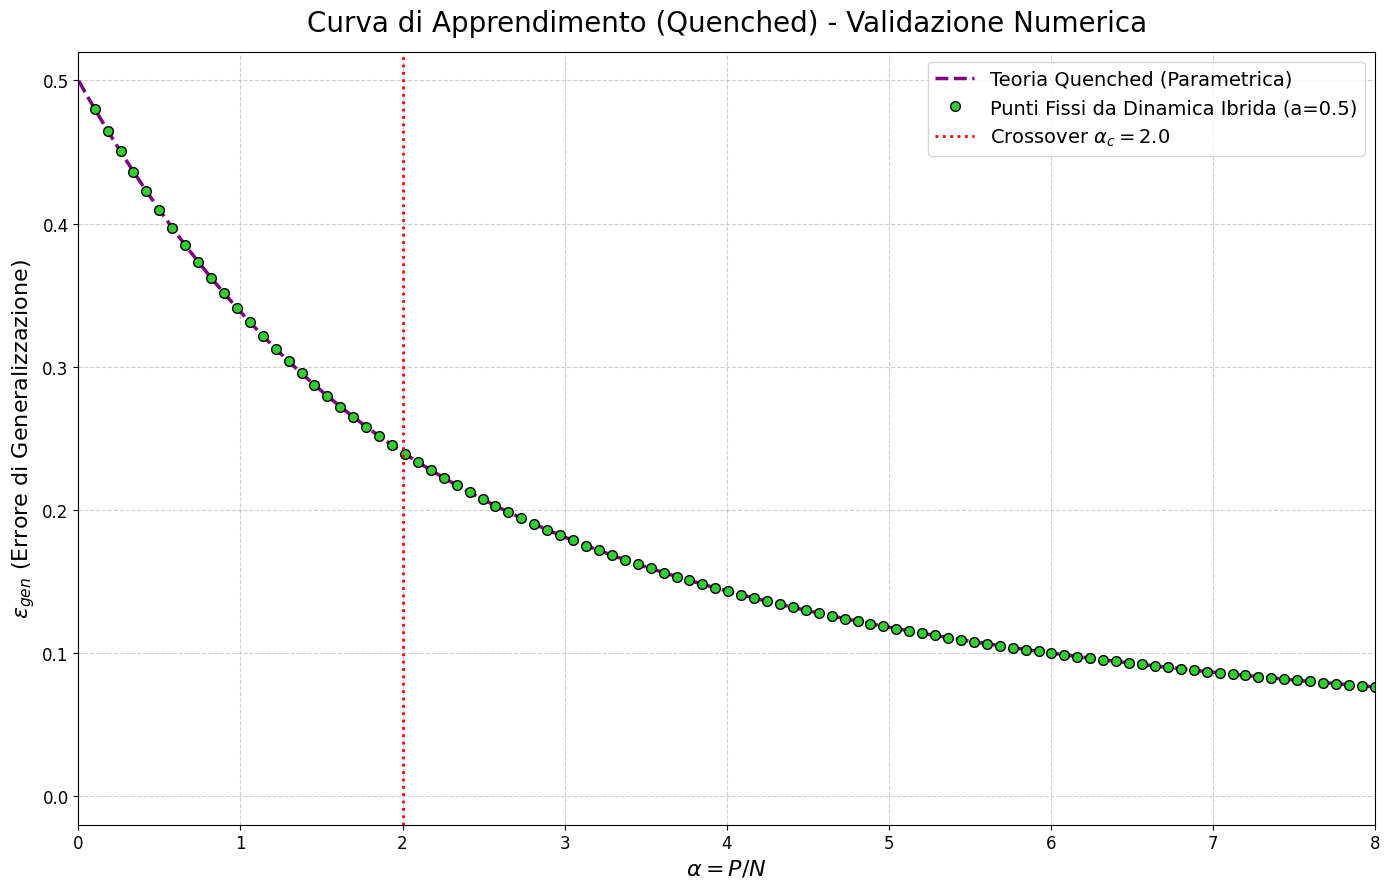

In [44]:
plot_results_quenched()


--- Esecuzione Plot di Confronto (Annealed) ---
Calcolo curva teorica parametrica...
Calcolo punti fissi da mappa iterativa (usando f2_annealed)...
Convergenza raggiunta all'epoca 9.
--- Calcolo Completato. Inizio Plotting. ---


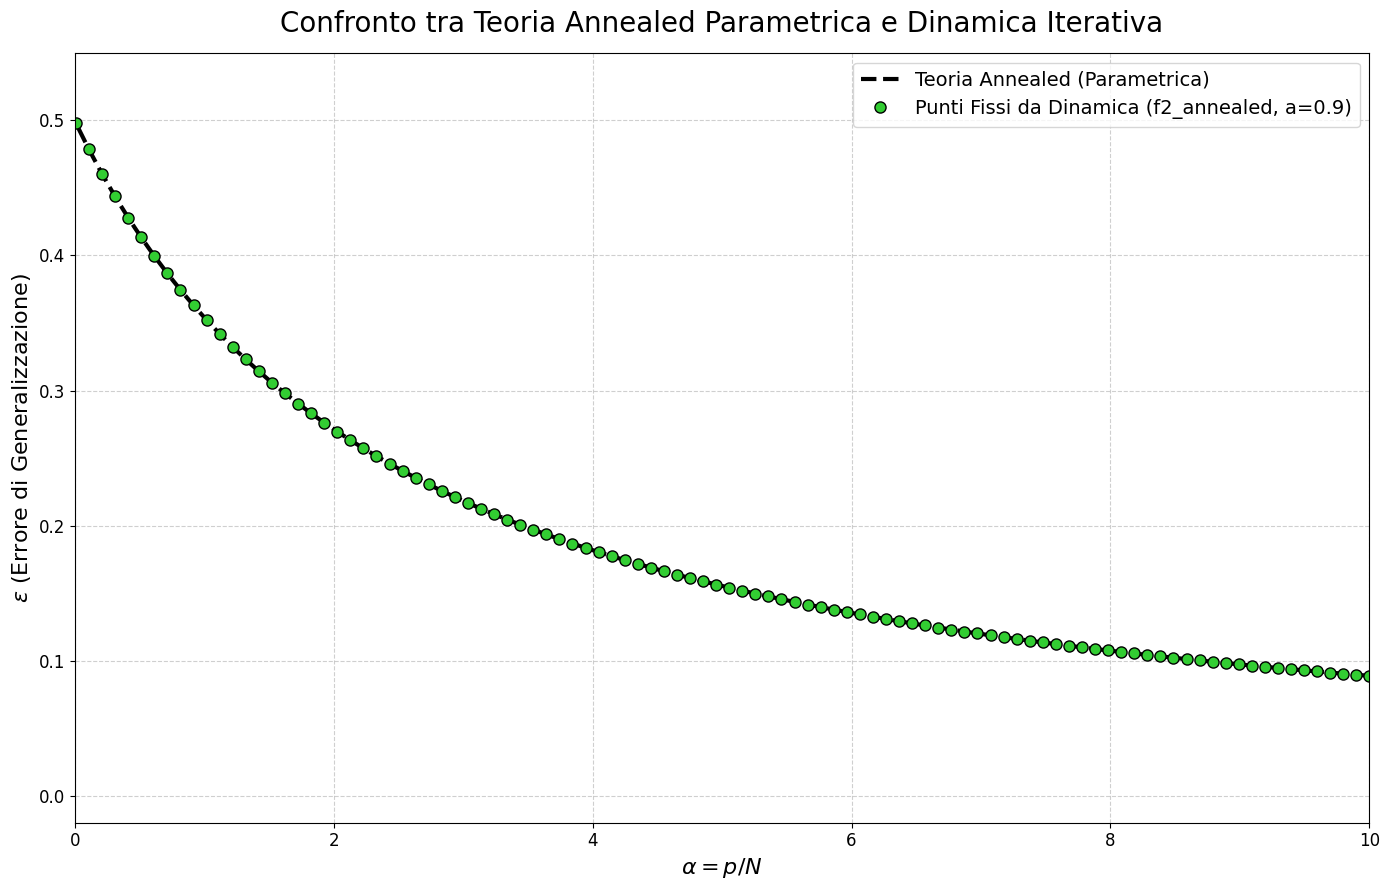

In [45]:
plot_results_annealed()

--- Inizio Analisi di Convergenza ---
Pre-calcolo dei punti fissi...
Calcolo delle derivate numeriche sulla griglia...
--- Analisi Completata. Inizio Plotting. ---


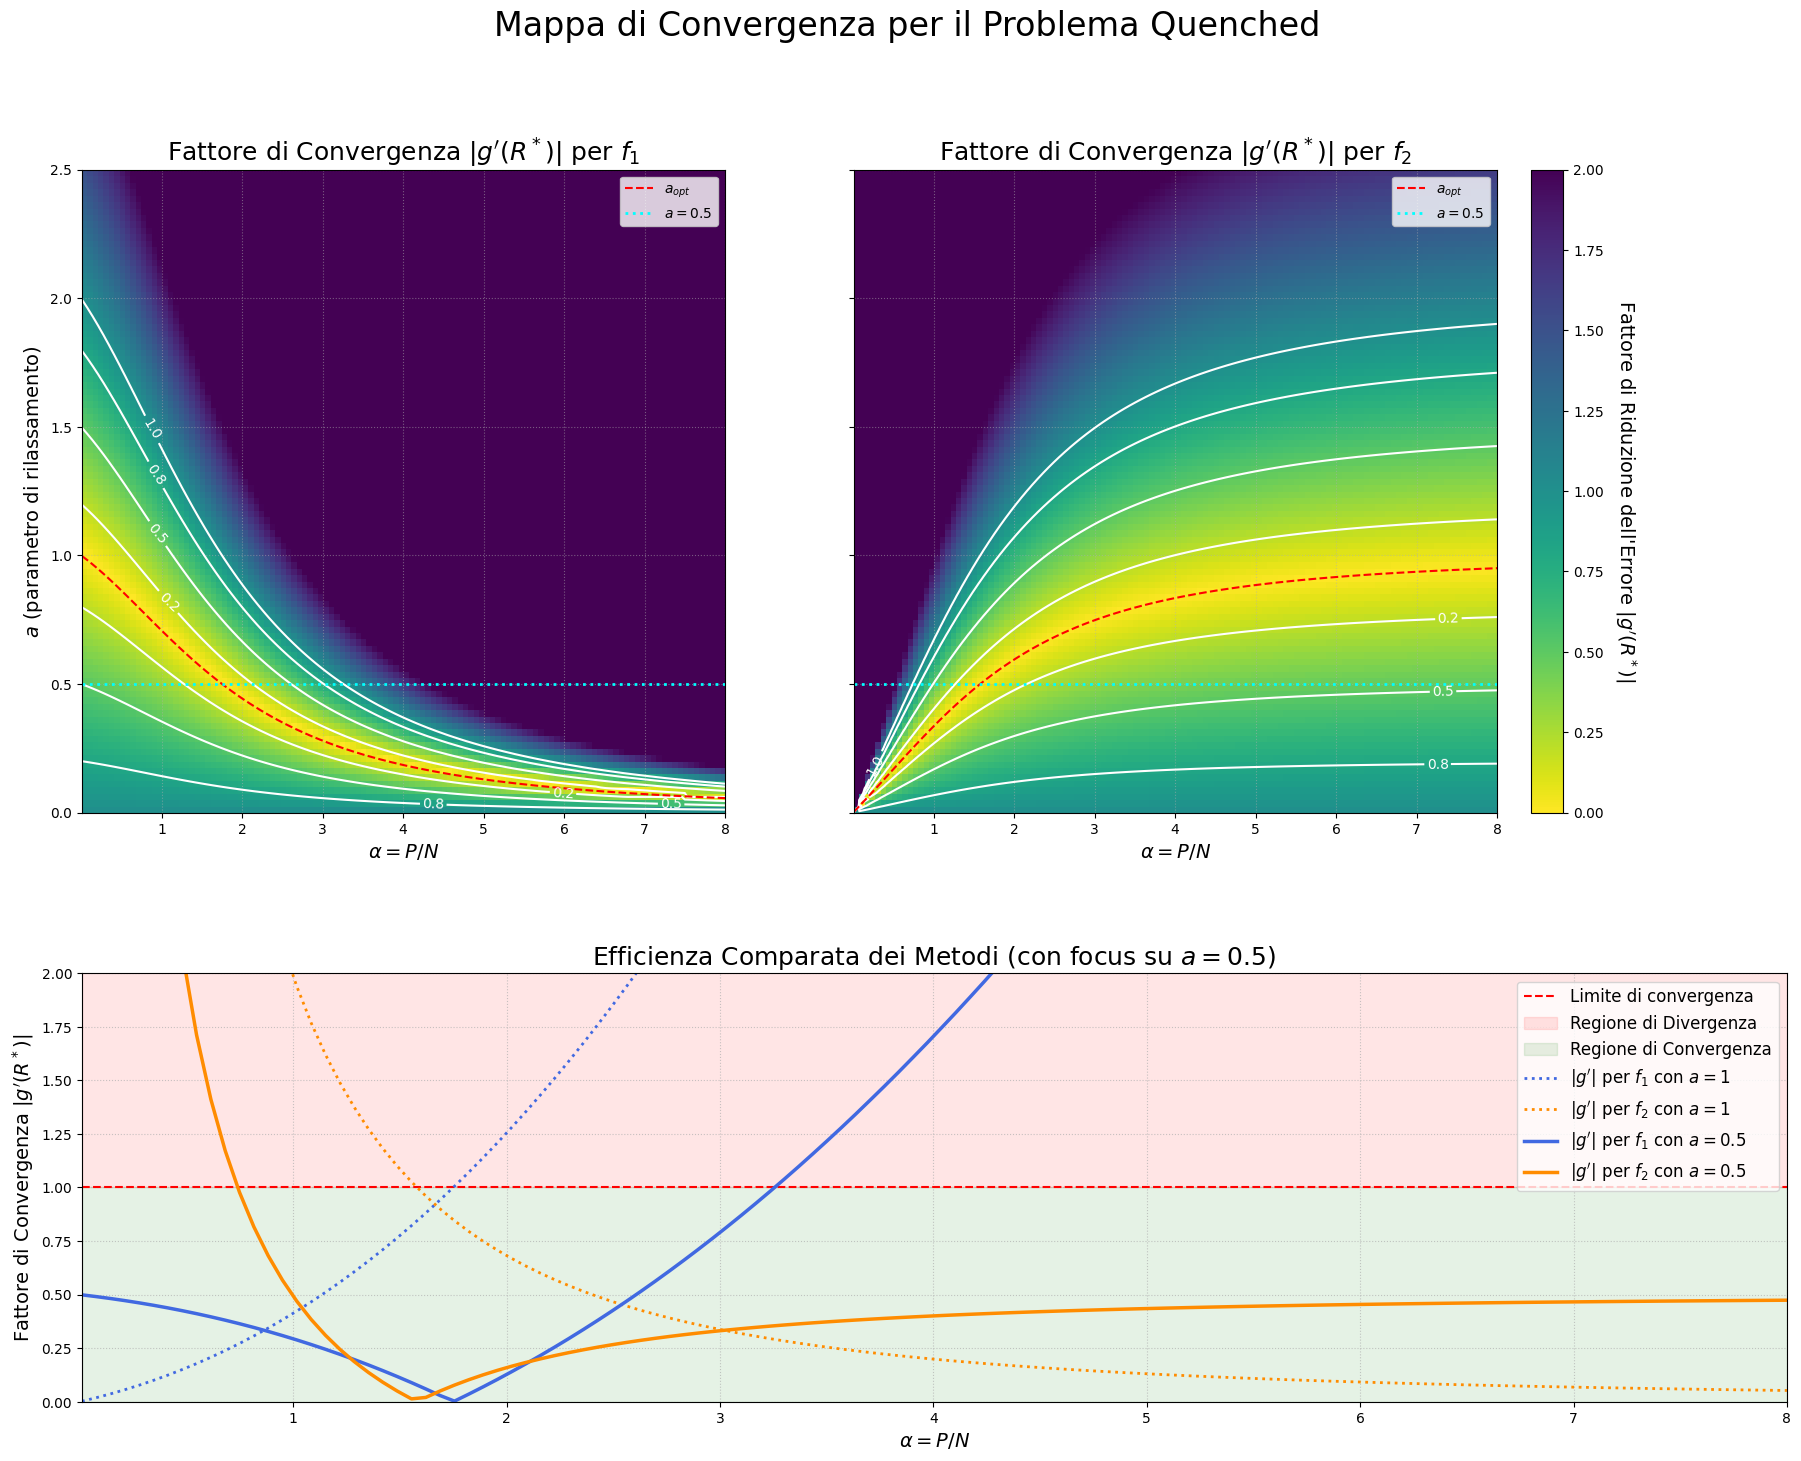

In [46]:
# Definizione delle etichette specifiche per il problema
quenched_labels = {
    'title': 'Mappa di Convergenza per il Problema Quenched',
    'x_label': r'$\alpha = P/N$',
    'y_label': r'$a$ (parametro di rilassamento)',
    'var_name': 'R'
}

plot_convergence_analysis(
    f1=f1_quenched,
    f2=f2_quenched,
    parametric_solver=parametric_solver_quenched,
    alpha_range=(0.01, 8),
    a_range=(0, 2.5),
    x_range=(0.01, 0.99),
    grid_resolution=(120, 100),
    a_highlight=0.5,
    labels=quenched_labels
)

--- Calcolo Dinamiche di Convergenza ---
--- Plotting Dinamiche ---


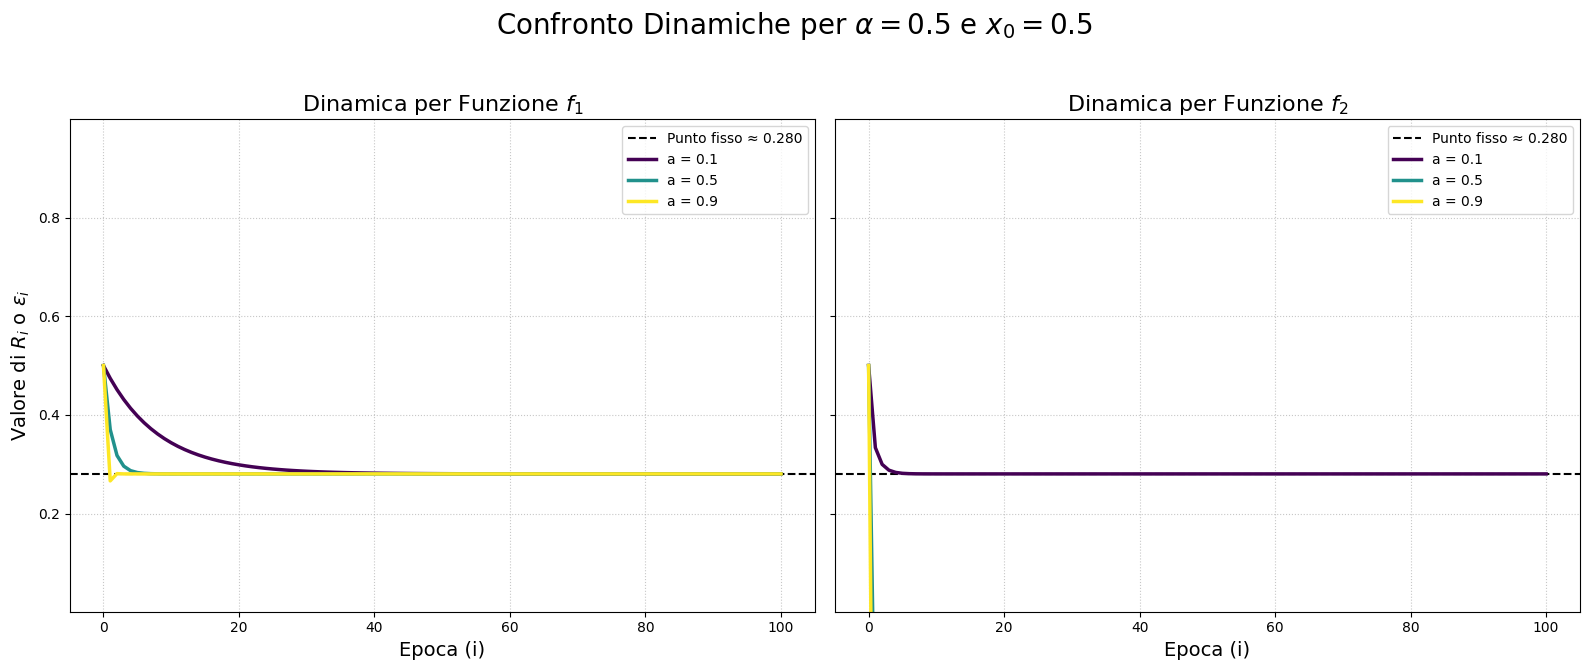

In [47]:
R_0 = 0.5
alpha = 0.5
a_values = np.array([0.1, 0.5, 0.9])
compare_dynamics(f1_quenched, f2_quenched, alpha, R_0, a_values, max_epochs=100, interval=[0.001, 0.999])


--- Calcolo Dinamiche di Convergenza ---
--- Plotting Dinamiche ---
Nessun punto fisso trovato per f_1 nell'intervallo.


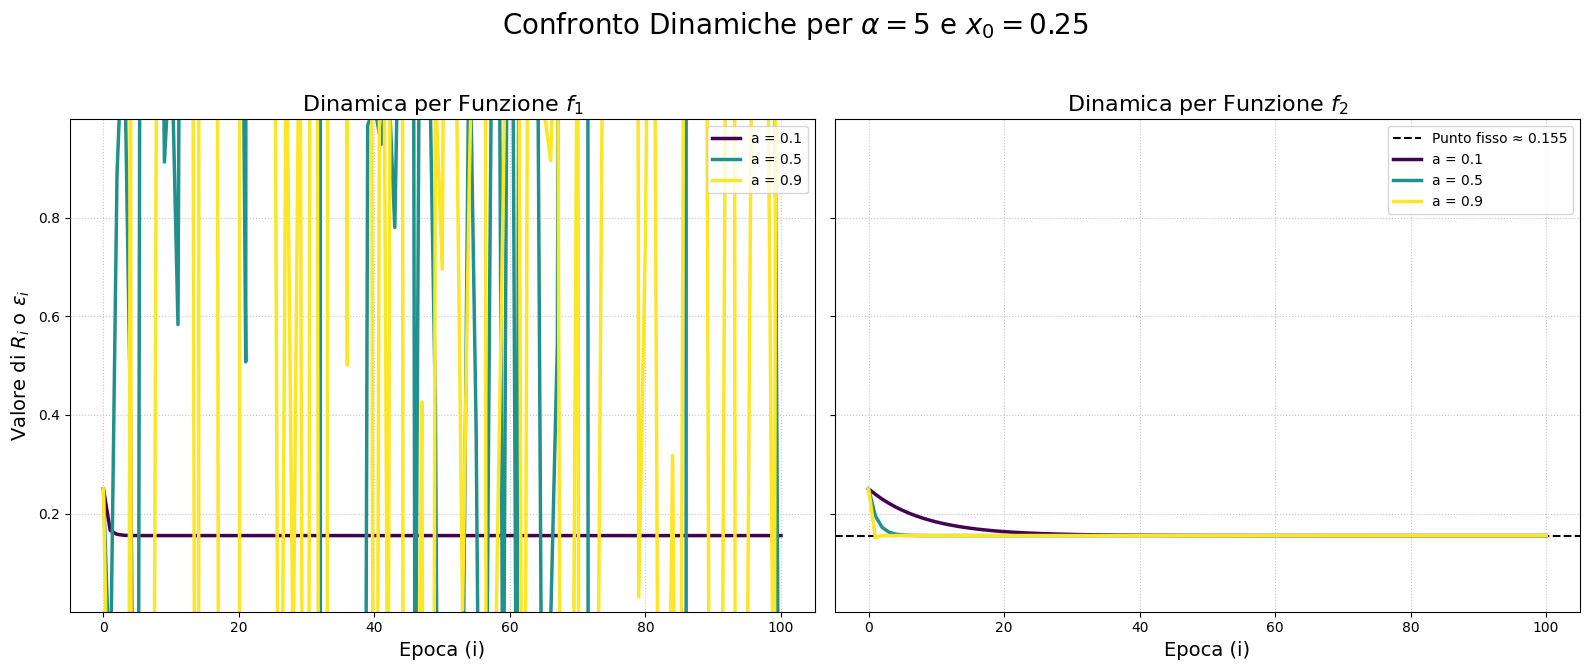

In [ ]:
eps_0 = 0.25
alpha = 5
a_values = np.array([0.1, 0.5, 0.9])
compare_dynamics(f1_annealed, f2_annealed, alpha, eps_0, a_values, max_epochs=100)


In [38]:
if __name__ == "__main__":

    try:
        num_cores = len(os.sched_getaffinity(0))
    except AttributeError:
        num_cores = os.cpu_count()
    print(f"*** Rilevati {num_cores} core CPU disponibili per la parallelizzazione. ***\n")

    experiment_runner = Experiment(name="Confronto Training N=20 e N=40")
    final_results = experiment_runner.run()

    # Stampa un riassunto dei risultati
    print("\n--- Riepilogo Risultati ---")
    print("N=20:")
    for p, mean, std in zip(final_results['train_sizes_20'], final_results['error_means_20'], final_results['error_stds_20']):
        alpha = p / 20
        print(f"  alpha = {alpha:.2f} (P={p}): errore = {mean:.4f} ± {std:.4f}")

    print("\nN=40:")
    for p, mean, std in zip(final_results['train_sizes_40'], final_results['error_means_40'], final_results['error_stds_40']):
        alpha = p / 40
        print(f"  alpha = {alpha:.2f} (P={p}): errore = {mean:.4f} ± {std:.4f}")

*** Rilevati 8 core CPU disponibili per la parallelizzazione. ***

--- Esecuzione Esperimento: Confronto Training N=20 e N=40 ---
--- Inizio simulazione parallela per N = 20 ---
Generazione di 1000 campioni di validazione per N=20...
Avvio di 1000 run in parallelo per N=20, P=1...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1960938367928038s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11692500114440918s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09187889099121094s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.9s
[Parallel(n_jobs=

Completato per N=20, P=1 in 3.77 secondi. Errore medio: 0.4876 ± 0.0786
Avvio di 1000 run in parallelo per N=20, P=10...


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12115597724914551s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08783721923828125s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0972909927368164s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1994885799415846s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 905 tasks      | elapsed:    1

Completato per N=20, P=10 in 2.12 secondi. Errore medio: 0.4167 ± 0.0700
Avvio di 1000 run in parallelo per N=20, P=20...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1322791576385498s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 950 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Completato per N=20, P=20 in 3.79 secondi. Errore medio: 0.3386 ± 0.0627
Avvio di 1000 run in parallelo per N=20, P=50...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.08862590789794922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 352 task

Completato per N=20, P=50 in 18.61 secondi. Errore medio: 0.2041 ± 0.0456
Avvio di 1000 run in parallelo per N=20, P=100...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   16.0s
[Paralle

Completato per N=20, P=100 in 64.18 secondi. Errore medio: 0.1124 ± 0.0303
Avvio di 1000 run in parallelo per N=20, P=150...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   27.5s
[Paralle

Training con noise terminato dopo 5000 epoche (max epoche raggiunto).


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  1.7min
[Paralle

Completato per N=20, P=150 in 135.92 secondi. Errore medio: 0.0735 ± 0.0213
Avvio di 1000 run in parallelo per N=20, P=200...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   50.4s
[Paralle

Training con noise terminato dopo 5000 epoche (max epoche raggiunto).


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Completato per N=20, P=200 in 239.93 secondi. Errore medio: 0.0526 ± 0.0163
--- Inizio simulazione parallela per N = 40 ---
Generazione di 1000 campioni di validazione per N=40...
Avvio di 1000 run in parallelo per N=40, P=1...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.08342647552490234s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05398297309875488s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11347651481628418s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09230947494506836s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.06686902046203613s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]:

Completato per N=40, P=1 in 0.91 secondi. Errore medio: 0.4942 ± 0.0560
Avvio di 1000 run in parallelo per N=40, P=2...


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09036707878112793s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03211045265197754s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.14889812469482422s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 779 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 926 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.01272082328

Completato per N=40, P=2 in 0.86 secondi. Errore medio: 0.4903 ± 0.0554
Avvio di 1000 run in parallelo per N=40, P=20...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10731053352355957s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18082714080810547s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 905 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 922 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:    2.5s
[

Completato per N=40, P=20 in 2.56 secondi. Errore medio: 0.4123 ± 0.0513
Avvio di 1000 run in parallelo per N=40, P=40...


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1737532615661621s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 580 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 740 tasks

Completato per N=40, P=40 in 7.69 secondi. Errore medio: 0.3429 ± 0.0480
Avvio di 1000 run in parallelo per N=40, P=100...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    9.1s
[Paralle

Completato per N=40, P=100 in 49.88 secondi. Errore medio: 0.2071 ± 0.0332
Avvio di 1000 run in parallelo per N=40, P=200...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   41.3s
[Paralle

Completato per N=40, P=200 in 177.39 secondi. Errore medio: 0.1142 ± 0.0216
Avvio di 1000 run in parallelo per N=40, P=300...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.5min
[Paralle

Completato per N=40, P=300 in 424.09 secondi. Errore medio: 0.0750 ± 0.0160

--- Simulazioni Completate ---

--- Riepilogo Risultati ---
N=20:
  alpha = 0.05 (P=1): errore = 0.4876 ± 0.0786
  alpha = 0.50 (P=10): errore = 0.4167 ± 0.0700
  alpha = 1.00 (P=20): errore = 0.3386 ± 0.0627
  alpha = 2.50 (P=50): errore = 0.2041 ± 0.0456
  alpha = 5.00 (P=100): errore = 0.1124 ± 0.0303
  alpha = 7.50 (P=150): errore = 0.0735 ± 0.0213
  alpha = 10.00 (P=200): errore = 0.0526 ± 0.0163

N=40:
  alpha = 0.03 (P=1): errore = 0.4942 ± 0.0560
  alpha = 0.05 (P=2): errore = 0.4903 ± 0.0554
  alpha = 0.50 (P=20): errore = 0.4123 ± 0.0513
  alpha = 1.00 (P=40): errore = 0.3429 ± 0.0480
  alpha = 2.50 (P=100): errore = 0.2071 ± 0.0332
  alpha = 5.00 (P=200): errore = 0.1142 ± 0.0216
  alpha = 7.50 (P=300): errore = 0.0750 ± 0.0160


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.1min finished



--- Esecuzione Plot di Confronto Completo ---
Calcolo teorie Annealed...
Convergenza raggiunta all'epoca 9.
Calcolo teorie Quenched...
Esecuzione procedura ibrida con crossover a alpha = 2.0...
Convergenza raggiunta all'epoca 26.
--- Calcoli Teorici Completati. Inizio Plotting. ---

Salvataggio figura in: master_comparison_plot_final.png


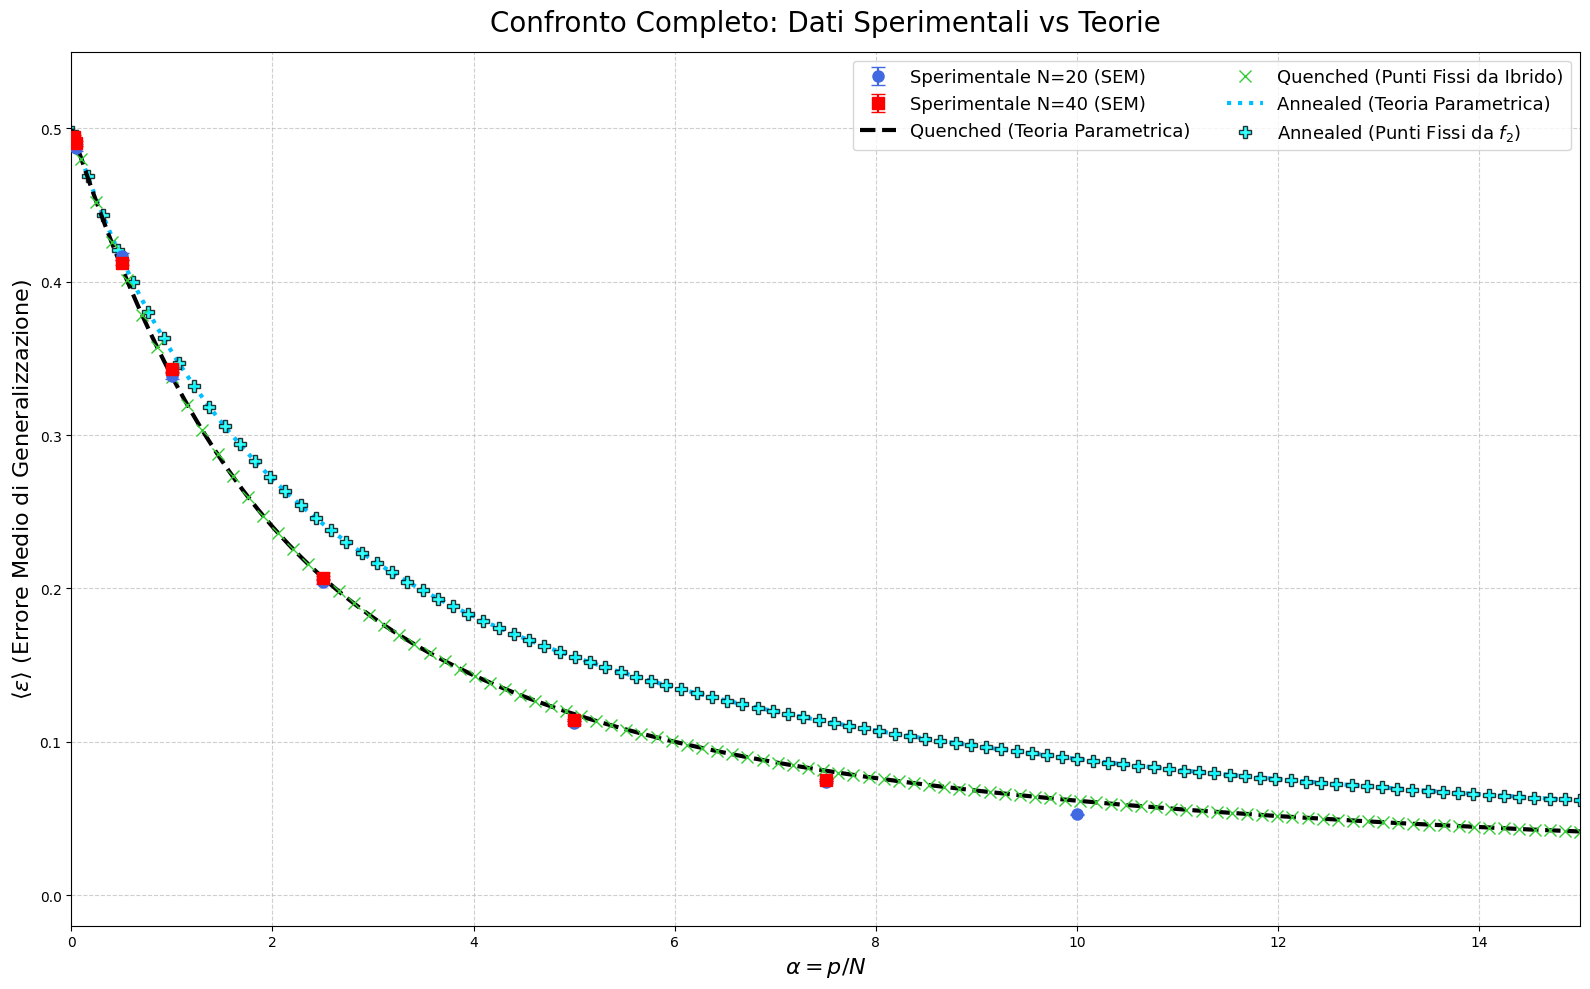

In [ ]:
experiment_runner.plot_advanced_comparison()